In [1]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'cv2'

In [4]:
def to_rgb(color):
    r,g,b = color
    return (int(r),int(g),int(b))

# Source: https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in wb.css3_hex_to_names.items():
        r_c, g_c, b_c = wb.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = wb.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Source Source: https://stackoverflow.com/questions/45043617/count-the-number-of-objects-of-different-colors-in-an-image-in-python
def find_colors(file_name):
    from skimage import io, morphology, measure
    from sklearn.cluster import KMeans

    img = io.imread(file_name)

    rows, cols, bands = img.shape
    X = img.reshape(rows*cols, bands)


    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.labels_.reshape(rows, cols)

    for i in np.unique(labels):
        blobs = np.int_(morphology.binary_opening(labels == i))
        color = np.around(kmeans.cluster_centers_[i])
        actual_name, closest_name = get_colour_name(to_rgb(color))
        count = len(np.unique(measure.label(blobs))) - 1
        
        print('Color: {}, RGB: {}  >>  Objects: {}'.format(closest_name,color, count))
        
def pixel_colors(file_name):
    '''
    Creating a dictionary of colours to see what colors are in images.
    '''
    from skimage import io
    if type(file_name) == str:
        img = io.imread(file_name)
    else:
        img = file_name
    
    new_img = np.copy(img)
    rows, cols, bands = new_img.shape
    
    dict_of_colours = {}
    for row in range(150,350):
        if row % 25 == 0:
            print(row)
        for col in range(0,50):
            pixel_color = new_img[row][col]
            actual, close = get_colour_name(pixel_color)
            if actual != None:
                if actual in dict_of_colours:
                    dict_of_colours[actual] += 1
                else:
                    dict_of_colours[actual] = 1
                list_of_colors.add(actual)
            else:
                if close in dict_of_colours:
                    dict_of_colours[close] += 1
                else:
                    dict_of_colours[close] = 1

    return dict_of_colours

In [5]:
import webcolors as wb
import numpy as np
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76
from PIL import Image

# Source: https://stackoverflow.com/questions/44428315/similar-color-detection-in-python

# Blurring image 
def blur_image(img, b):
    if b == "average":
        kernel = np.ones((3,6),np.float32)/25
        blurred = cv2.filter2D(img,-1,kernel)
    elif b == "gaussian":
    # Gaussian Blur
        blur=cv2.GaussianBlur(img,(13,13),0)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    elif b == "bilateral":
    # Bilaterial Filter
        blur=cv2.bilateralFilter(img,4,25,25)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    return blurred

def turn_array(rgb):
    '''
    turn rgb into np.array
    '''
    return np.uint8(np.asarray([[rgb]]))

def turn_rgb_2_lab(color, lab):
    '''
    Convert RGB to CIE 1976 L*a*b*
    '''
    return deltaE_cie76(rgb2lab(color),lab)

def rgb_to_id(rgb, threshold, color, ids, lab):
    '''
    Convert rgb to id
    '''
#     print(get_colour_name(color), color, ids)
    color_3d = turn_array(color)
    dE_color = turn_rgb_2_lab(color_3d, lab)
    rgb[dE_color < threshold] = ids
#     rgb[dE_color < threshold] = color

    return rgb

def ref_colour(rgb):
# def ref_colour():
    '''
    Finding colours within a range of the colour input
    input = pixel
    '''
    rgb = io.imread('https://i.stack.imgur.com/npnrv.png') # to show where the images overlap
    new_rgb = np.copy(rgb)
    
    lab = rgb2lab(new_rgb)
    
    threshold = 15  
    
    # Black = Grey 
    black = [0, 0, 0]
    dimgrey = [105, 105, 105]
    darkslategrey = [47, 79, 79]
    lightgrey = [211, 211, 211]
    gainsboro = [220, 220, 220]
    grey = [128, 128, 128]
    lightslategrey = [119, 136, 153]
    darkgrey = [169, 169, 169]
    
    # NOTE: USED TO BE -1 BUT CHANGED AS VALUE NEEDED FOR CROSS ENTROPY - CAN'T HAVE 0
    rgb_to_id(new_rgb, threshold, black, 0, lab)
    rgb_to_id(new_rgb, threshold, dimgrey, 0, lab)
    rgb_to_id(new_rgb, threshold, darkslategrey, 0, lab)
    rgb_to_id(new_rgb, threshold, lightgrey, 0, lab)
    rgb_to_id(new_rgb, threshold, gainsboro, 0, lab)
    rgb_to_id(new_rgb, threshold, grey, 0, lab)
    rgb_to_id(new_rgb, threshold, lightslategrey, 0, lab)
    rgb_to_id(new_rgb, threshold, darkgrey, 0, lab)
    
    # Red = OrangeRed
    red = [255,0,0]
    orangered = [255, 69, 0]
    firebrick = [181,17,17]
    
    rgb_to_id(new_rgb, threshold, red, 1, lab)
    rgb_to_id(new_rgb, threshold, orangered, 1, lab)
    rgb_to_id(new_rgb, threshold, firebrick, 1, lab)
    
    # Blue
    blue = [0, 0, 255]
    darkslateblue = [72, 61, 139]
    midnightblue = [25, 25, 112]
    mediumblue = [0, 0, 205]
    
    rgb_to_id(new_rgb, threshold, blue, 2, lab)
    rgb_to_id(new_rgb, threshold, darkslateblue, 2, lab)
    rgb_to_id(new_rgb, threshold, midnightblue, 2, lab)
    rgb_to_id(new_rgb, threshold, mediumblue, 2, lab)
    
    # Purple = Dark Violet = Medium Purple = Darkorchid
    purple = [128,0,128]
    darkviolet = [177,10,255]
    mediumpurple = [147, 112, 219]
    darkorchid = [153, 50, 204]
    
    rgb_to_id(new_rgb, threshold, purple, 3, lab)
    rgb_to_id(new_rgb, threshold, darkviolet, 3, lab)
    rgb_to_id(new_rgb, threshold, mediumpurple, 3, lab)
    rgb_to_id(new_rgb, threshold, darkorchid, 3, lab)
    
    # Green is same as Lime and limegreen
    green = [0,128,0]
    lime = [0,255,0]
    limegreen = [50, 205, 50]
    
    rgb_to_id(new_rgb, threshold, green, 4, lab)
    rgb_to_id(new_rgb, threshold, lime, 4, lab)
    rgb_to_id(new_rgb, threshold, limegreen, 4, lab)
    
    # Orange is same as dark orange
    orange = [255, 165, 0]
    darkorange = [255, 140, 0]
    chocolate = [180,101,24]
    
    rgb_to_id(new_rgb, threshold, orange, 5, lab)
    rgb_to_id(new_rgb, threshold, darkorange, 5, lab)
    rgb_to_id(new_rgb, threshold, chocolate, 5, lab)
    
    # Yellow = Gold
    yellow = [255,255,0]
    gold = [255, 215, 0]
    goldenrod = [218, 165, 32]
    goldenrod2 = [183,178,36]
    darkgoldenrod = [184, 134, 11]
    
    rgb_to_id(new_rgb, threshold, yellow, 6, lab)
    rgb_to_id(new_rgb, threshold, gold, 6, lab)
    rgb_to_id(new_rgb, threshold, goldenrod, 6, lab)
    rgb_to_id(new_rgb, threshold, goldenrod2, 6, lab)
    rgb_to_id(new_rgb, threshold, darkgoldenrod, 6, lab)
    
    # Magenta/Fuschia
    magenta = [255,0,255]
    darkmagenta = [139, 0, 139]
    
    magenta_threshold = 20
    
    rgb_to_id(new_rgb, magenta_threshold, magenta, 7, lab)
    rgb_to_id(new_rgb, magenta_threshold, darkmagenta, 7, lab)
    
#     new_grey = new_rgb
    new_grey = cv2.cvtColor( new_rgb, cv2.COLOR_RGB2GRAY ) # convert image to grayscale
    
    return new_grey
# rgb = ref_colour()
# plt.imshow(rgb)

def convert_to_id_image(image):
    '''
    convert rgb images to id
    '''
    returned_grey_image = ref_colour(image)
    rows, cols = returned_grey_image.shape
    g_y = np.copy(returned_grey_image)
    for x in range(0, rows):
        for j in range(0,cols):
#             if returned_grey_image[x][j] > 7: # Setting values in the array to void if they're not in labels
#                 returned_grey_image[x][j] = -1 # this created issue with cross_entropy
            if returned_grey_image[x][j] > 7: # Setting values in the array to void if they're not in labels
                g_y[x][j] = 0
    print(np.unique(g_y))
    return g_y

def convert_to_rgb_image(id_image):
    '''
    Convert id back to rgb 
    '''
    rows, cols = id_image.shape

    black = [0, 0, 0]# id = 0
    red = [255,0,0] # id = 1
    blue = [0, 0, 255] # id = 2
    darkviolet = [177,10,255] # id = 3
    lime = [0,255,0] # id = 4
    darkorange = [255, 140, 0] # id = 5
    yellow = [255, 255, 0] # id = 6
    magenta = [255,0,255] # id = 7
    
    colors = [ black, red, blue, darkviolet, lime, darkorange, yellow, magenta]
    new_image = np.zeros((rows,cols,3))
    for x in range(0, rows):
        for j in range(0,cols):
            pixel_value = int(id_image[x][j])
            if pixel_value > 7: # Setting values in the array to black if they're not in labels
                print(pixel_value)
                new_image[x][j] = black
            else:
                new_image[x][j] = colors[pixel_value] # setting id to colours - values between 1-7
    return new_image.astype(np.uint8)

In [6]:
# Applying Weighting algorithm to an image
value = 3
def weighting_algo(id_image):
    '''
    Creating weighting of an image
    '''
    image = id_image
    x,y = image.shape
    weighted_image = np.zeros((x,y))
    for j in range(x):
        for k in range(y):
            # Setting weights for the image
#             if(image[j][k]==1):
#                 w2 = 11.459
#             elif(image[j][k] == 2):
#                 w2 = 5.63
#             elif(image[j][k]== 3):
#                 w2 = 11.007 
#             elif(image[j][k] == 4):
#                 w2 = 14.368 
#             elif(image[j][k]== 5):
#                 w2 = 3.336 
#             elif(image[j][k]== 6):
#                 w2 = 13.647 
#             elif(image[j][k]== 7):
#                 w2 = 16.978 
            if(image[j][k]==1):
                w2 = 10 * value
            elif(image[j][k] == 2):
                w2 = 10 * value
            elif(image[j][k]== 3):
                w2 = 5 * value
            elif(image[j][k] == 4):
                w2 = 15 * value
            elif(image[j][k]== 5):
                w2 = 8 * value
            elif(image[j][k]== 6):
                w2 = 6 * value
            elif(image[j][k]== 7):
                w2 = 10 * value
            else:
                w2 = 0
            if(j!=0 and j!=x-1):
                next_pix = image[j+1][k]
                prev_pix = image[j-1][k]
                # Taking the derivative of the pixels
                if(np.absolute((next_pix-prev_pix))>0 and w2!=0):
                    w1 = 10  
                else:
                    w1 = 0
            else:
                w1 = 0
            w = 1 + w1 + w2
            weighted_image[j][k] = w
    return weighted_image

#### Make Segments

In [7]:
# Labels (=1 to 7) are consistent across images and map the following original colors :

#  % Red
#  % Blue
#   % Purple
#   % Green
#  % Orange
#     % Yellow
#     % Magenta

In [8]:
# Setting the directories
import os
cwd = os.getcwd()

whole_raw_image_folder = cwd + '/datasets/OCTData/alldata/whole_raw_image/'
brushlet_enhanced_folder = cwd + '/datasets/OCTData/alldata/brushlet_enhanced/'
brushlet_denoised_folder = cwd + '/datasets/OCTData/alldata/brushlet_denoised/'
manual_label_folder = cwd + '/datasets/OCTData/alldata/manual_label/'
all_labels_folder = cwd + '/datasets/OCTData/alldata/all_labels/'
sim_labels_folder = cwd + '/datasets/OCTData/alldata/my_labels/'
# corrected_labels_folder = cwd + '/datasets/OCTData/alldata/labels_corrected/'
corrected_labels_folder = cwd + '/datasets/OCTData/alldata/png_labels_method/'

list_of_folders = [whole_raw_image_folder, brushlet_denoised_folder, brushlet_enhanced_folder, manual_label_folder, all_labels_folder, sim_labels_folder, corrected_labels_folder]
print(len(list_of_folders))
def list_all_files(directory):
    from os import listdir
    from os.path import isfile, join
    all_labels_files = [f for f in listdir(directory) if isfile(join(directory, f))]
    all_labels_files.sort()
    return all_labels_files

files_list = []
for folders in list_of_folders:
    files_list.append(list_all_files(folders))

7


In [9]:
# Creating list of file names
new_file_list = []
# for i in range(len(files_list[0])):
#     for j in range(len(files_list)):
#         if files_list[j][i][:4] == 'con_':
#             string = files_list[j][i][4:]
#             file_name = string[:19].replace('.','')
#         elif files_list[j][i][:6] == 'label_':
#             string = files_list[j][i][6:]

for i in files_list[0]:
    if i[:4] == 'con_':
        string = i[4:]
        file_name = string[:19].replace('.','')
    new_file_list.append(file_name)

new_file_list.sort()

# Removing Unwanted Files
unwanted_files = []
# print(len(new_file_list))
anon_count = 0
for count, i in enumerate(new_file_list):
    if i == 'H3_N02186_RV_1_270' or i == 'H3_N02186_RV_1_400' or i == 'H4_N03210_LV_1_400' or i == 'H4_N03210_RV_1_390':
        print(count,i)
        unwanted_files.append(count)
    elif i == 'H4_N03210_RV_1_400' or i == 'H5_N03290_LV_1_420' or i == 'H6_N03320_LVS_1_455':
        print(count,i)
        unwanted_files.append(count)
#     Second set of unwanted files if not clear segments
    elif i == 'H1_N01848_LV_1_194' or i == 'H1_N01848_LV_1_300' or i == 'H3_N02186_LVS_1_265':
        print(count,i)
        unwanted_files.append(count)
    elif i == 'H6_N03320_LV_1_404' or i == 'H6_N03320_LVS_1_455':
        print(count,i)
        unwanted_files.append(count)
    elif i == 'H1_N01848_LV_1_194' or i == 'H1_N01848_LV_1_300' or i == 'H2_N02047_LVS_1_400' or i == 'H2_N02047_LVS_1_420' or i == 'H3_N02186_LVS_1_265' or i == 'H4_N03210_RV_1_390' or i == 'H4_N03210_RV_1_400' or i == 'H5_N03290_LV_1_420' or i == 'H6_N03320_LV_1_404' or i == 'H6_N03320_LVS_1_455' or i == 'H6_N03320_RA_1_420' or i == 'H8_N03585_RA_1_345':
        print(count,i)
        unwanted_files.append(count)
#     elif i[11] == 'V':
#         print(count,i)
#         unwanted_files.append(count)
# #         anon_count+=1
#     print(len(new_file_list) - anon_count)
print(unwanted_files)

2 H1_N01848_LV_1_194
3 H1_N01848_LV_1_300
8 H2_N02047_LVS_1_400
9 H2_N02047_LVS_1_420
18 H3_N02186_LVS_1_265
24 H3_N02186_RV_1_270
25 H3_N02186_RV_1_400
28 H4_N03210_LV_1_400
33 H4_N03210_RV_1_390
34 H4_N03210_RV_1_400
40 H5_N03290_LV_1_420
46 H6_N03320_LVS_1_455
47 H6_N03320_LV_1_404
49 H6_N03320_RA_1_420
57 H8_N03585_RA_1_345
[2, 3, 8, 9, 18, 24, 25, 28, 33, 34, 40, 46, 47, 49, 57]


In [10]:
print(len(unwanted_files))
print(len(new_file_list))

15
65


### Saving Image Helpers

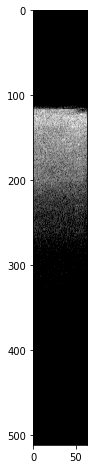

In [11]:
def segment_image_multiple(image, left_bound, right_bound, split):
    '''
    Segment image at intervals of half of split to have more training data
    
    Segment image by input of image, left bound and right bound, and split int 
    '''
    list_of_images = []
    bounds = right_bound - left_bound
    quot, rem = divmod(bounds, split)
#     print(quot, rem)
    ranged = np.arange(0,quot,0.7)
    ranged = ranged[:-1] # change size of range to ensure all have same length
    for i in ranged:
#         print(i*split, (i+1)*split)
        if len(image.shape) == 2:
            cropped_image = crop_image(image, int(i*split), int((i+1) * split))
            list_of_images.append(cropped_image)
        elif len(image.shape) == 3:
            cropped_image = crop_image(image, int(i*split), int((i+1) * split), False)
            list_of_images.append(cropped_image)
#         print(cropped_image.shape)
    return list_of_images

whole_raw_1 = plt.imread(whole_raw_image_folder+files_list[0][0])
segmented_whole = segment_image_multiple(whole_raw_1, 0, 600, 64)

for i in segmented_whole:
    plt.imshow(i)

In [12]:
# Saving images
def crop_and_save_raw(image, src_direct, name):
    dst_drc = src_direct + 'Train/'

    # Crop all images
    if len(image.shape) == 2:
        height, width = image.shape
        if width > 600:
            image = crop_image(image, 0, 600) # Crop all images at 512,600
    elif len(image.shape) == 3:
        height, width, colour = image.shape
        if width > 600:
            image = crop_image(image, 0, 600, colour) # Crop all images at 512,600
#     plt.imshow(image)
#     print(image.shape)
#     segmented_images = segment_image(image, 0, 600, 64)
    segmented_images = segment_image_multiple(image, 0, 600, 64)
#     print(len(segmented_images))
#     fig, axes = plt.subplots(nrows=1, ncols=len(segmented_images), figsize=(9,20))
#     for i, ax in enumerate(axes):
#         ax.imshow(segmented_images[i])
#         ax.set_title(i)
#     plt.show()
    for i in range(len(segmented_images)):
        image_name = dst_drc+name+'_'+str(i+1)+'.png'
        cur_image = segmented_images[i]
        imsave(image_name, cur_image)
#     return image_name

# Saving labels and weights
def crop_and_save_label(label, src_direct, name):
    id_dst_drc = src_direct + 'Train/segmented_ids/'
    weight_dst_drc = src_direct + 'Train/weights/'
    height, width = label.shape
    
    label[440:,:] = 0
    
    if width > 600:
        label = crop_image(label, 0, 600)
    if height != 512:
        amount = 512 - height
        id_full = np.zeros((amount,600))
        label = np.concatenate((label, id_full))
    
    rgb_image = convert_to_rgb_image(label) 
    plt.imshow(rgb_image)
#     segmented_labels = segment_image(label, 0, 600, 64)
    segmented_labels = segment_image_multiple(label, 0, 600, 64)
    
    for i in range(len(segmented_labels)):
        id_name = id_dst_drc+'id_'+name+'_'+str(i+1)+'.npy'
        weight_name = weight_dst_drc+'weight_'+name+'_'+str(i+1)+'.npy'
        
        cur_label = segmented_labels[i]
        
        # convert image_id into weighted image 
        weighted_image = weighting_algo(cur_label)
        
        # Saving labels and weights
        np.save(id_name,np.array(cur_label))
        np.save(weight_name,np.array(weighted_image))

    return name

# Saving images
def save_label(image, src_direct, name):
    dst_drc = src_direct
    
    # Crop all images
    if len(image.shape) == 2:
        height, width = image.shape
        if width > 600:
            image = crop_image(image, 0, 600) # Crop all images at 512,600
    elif len(image.shape) == 3:
        height, width, colour = image.shape
        if width > 600:
            image = crop_image(image, 0, 600, colour) # Crop all images at 512,600
    id_image = convert_to_id_image(image)
    image_name = dst_drc+"label_"+name+'.png'
    imsave(image_name, id_image)
#     rgb_image = convert_to_rgb_image(id_image)
#     plt.imshow(id_image)
#     plt.imshow(rgb_image)
#     print(id_image.shape)
#     print(np.unique(id_image))
#     return image_name

In [75]:
def remove_files(mydir, ext):
    filelist = [ f for f in os.listdir(mydir) if f.endswith(ext) ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))
remove = False
if remove:
    whole_raw_image_folder_rem = cwd + '/datasets/OCTData/alldata/whole_raw_image/Train/'
    brushlet_enhanced_folder_rem = cwd + '/datasets/OCTData/alldata/brushlet_enhanced/Train/'
    brushlet_denoised_folder_rem = cwd + '/datasets/OCTData/alldata/brushlet_denoised/Train/'
    manual_label_folder_rem = cwd + '/datasets/OCTData/alldata/manual_label/Train/'
    all_labels_folder_ids_rem = cwd + '/datasets/OCTData/alldata/all_labels/Train/segmented_ids/'
    all_labels_folder_weights_rem = cwd + '/datasets/OCTData/alldata/all_labels/Train/weights/'
    sim_labels_folder_ids_rem = cwd + '/datasets/OCTData/alldata/my_labels/Train/segmented_ids/'
    sim_labels_folder_weights_rem = cwd + '/datasets/OCTData/alldata/my_labels/Train/weights/'
#     corrected_labels_folder_ids_rem = cwd + '/datasets/OCTData/alldata/labels_corrected/Train/segmented_ids/'
#     corrected_labels_folder_weights_rem = cwd + '/datasets/OCTData/alldata/labels_corrected/Train/weights/'
    corrected_labels_folder_ids_rem = cwd + '/datasets/OCTData/alldata/png_labels_method/Train/segmented_ids/'
    corrected_labels_folder_weights_rem = cwd + '/datasets/OCTData/alldata/png_labels_method/Train/weights/'
    
    remove_files(whole_raw_image_folder_rem, '.png')
    remove_files(brushlet_enhanced_folder_rem, '.png')
    remove_files(brushlet_denoised_folder_rem, '.png')
    remove_files(manual_label_folder_rem, '.png')
    remove_files(all_labels_folder_ids_rem, '.npy')
    remove_files(all_labels_folder_weights_rem, '.npy')
    remove_files(sim_labels_folder_ids_rem, '.npy')
    remove_files(sim_labels_folder_weights_rem, '.npy')
    remove_files(corrected_labels_folder_ids_rem, '.npy')
    remove_files(corrected_labels_folder_weights_rem, '.npy')

In [76]:
# The values of the conversion by Elsa
values = [0.0, 0.007843138, 0.011764706, 0.015686275, 0.019607844, 0.023529412, 0.02745098]


0
[0 3 5 6]

1
[0 3 5 6]

4
[0 1 2]

5
[0 1 2]

6
[0 3 4 5 7]

7
[0 3 4 5 7]

10
[0 1 2]

11
[0 1 2]

12
[0 2 3 4]

13
[0 2 3 4]

14
[0 1 2 4]

15
[0 1 2 4]

16
[0 2 4]

17
[0 2 4]

19
[0 1 2 4]

20
[0 3 4 5 7]

21
[0 3 5 7]

22
[0 1 2]

23
[0 1 2]

26
[0 2 3]

27
[0 2 3 4]

29
[0 2 3]

30
[0 2 3]

31
[0 1 2]

32
[0 1 2]

35
[0 3 5 6]

36
[0 3 5 6]

37
[0 1 2 3]

38
[0 1 2 3]

39
[0 2 3]

41
[0 1 2]

42
[0 1 2]

43
[0 3 4 5 7]

44
[0 3 4 5 7]

45
[0 1 2 3]

48
[0 1 2 3 4]

50
[0 1 2]

51
[0 1 2]

52
[0 2 3]

53
[0 2 3]

54
[0 2 3]

55
[0 1 2]

56
[0 2 3]

58
[0 1 2]

59
[0 1 2]

60
[0 1 2]

61
[0 1 2]

62
[0 1 2]

63
[0 1 2]

64
[0 1 2]


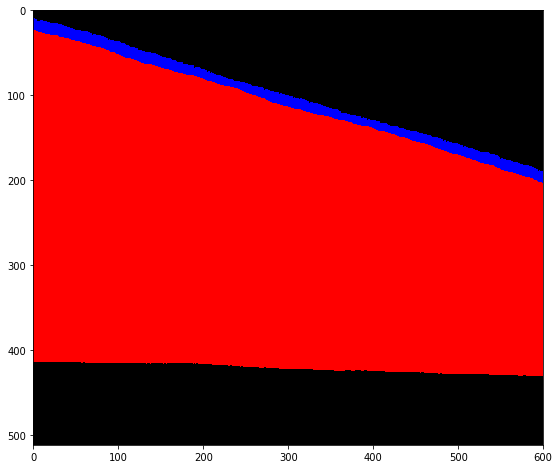

In [77]:
# Extensions
raw_ext = '.tif'
label_ext = '.JPG'

whole_raw_ext = '.tif'
man_lab_ext = '.JPG'
everything_else_ext = '.png'

# Loop through images to determine whether their weights and they are looking correct
l_values = set()
for i in range(len(files_list[0])):
# for i in range(20, len(files_list[0])):
    # choosing files I don't like
    if i not in unwanted_files:
        print()
        print(i)
        whole_raw = plt.imread(whole_raw_image_folder+files_list[0][i]) # whole raw image - needs to be segmented and saved
        b_d = plt.imread(brushlet_denoised_folder+files_list[1][i]) # whole brushlet denoised image - needs to be segmented and saved
        b_e = plt.imread(brushlet_enhanced_folder+files_list[2][i]) # whole brushlet enhanced image - needs to be segmented and saved
        man_lab = plt.imread(manual_label_folder+files_list[3][i]) # main_label (coloured) - needs to be segmented and saved
        label = plt.imread(all_labels_folder+files_list[4][i]) # label (ids) - needs to be segmented and used to create weight
        label = ((label*7)/np.max(values)).astype(int)
        
        # Create my labels from manual labels
#         save_label(man_lab, sim_labels_folder, new_file_list[i])
        sim_label = plt.imread(sim_labels_folder+files_list[5][i]) # label (ids) - needs to be segmented and used to create weight

        correct_label = plt.imread(corrected_labels_folder+'label_'+new_file_list[i]+'_labels.png') # label (ids) - needs to be segmented and used to create weight
#         correct_label = plt.imread(corrected_labels_folder+files_list[6][i]) # label (ids) - needs to be segmented and used to create weight
        correct_label = ((correct_label*7)/np.max(values)).astype(int)
        print(np.unique(correct_label))
        
        # crop and save all files necessary
#         crop_and_save_raw(whole_raw, whole_raw_image_folder, new_file_list[i])
#         crop_and_save_raw(b_d, brushlet_denoised_folder, new_file_list[i])
#         crop_and_save_raw(b_e, brushlet_enhanced_folder, new_file_list[i])
#         crop_and_save_raw(man_lab, manual_label_folder, new_file_list[i])
        crop_and_save_label(label, all_labels_folder, new_file_list[i])
        crop_and_save_label(sim_label, sim_labels_folder, new_file_list[i])
        crop_and_save_label(correct_label, corrected_labels_folder, new_file_list[i])

#         image_array = [whole_raw, b_d, b_e, man_lab, label]    
#         image_name = ['whole_raw_1', 'b_d_1', 'b_e_1', 'man_lab_1', 'label_1']

#         fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))
#         fig.suptitle(new_file_list[i], size=14)
#         for j, ax in enumerate(axes):
#             ax.margins(0.05, 0.15)
#             ax.imshow(image_array[j])
#             ax.set_title(image_name[j])

#         Priting values of array to see if they're between 0-7
#         print(np.unique(label))

# for i in range(512):
#   print(label_1[i])
# print(np.max(label))
# print(np.min(label))
# print(np.unique(label))

In [78]:
print(files_list[0][54])

con_H7_N03555_RA_1_302.tif


In [20]:
# print(correct_label.shape)
# colors = [ 'black', 'red', 'blue', 'purple', 'lime', 'orange', 'yellow','magenta']
# for count, i in enumerate(colors):
#     print(count, i)
# print(colors[7])

In [21]:
# # for i in range(len(files_list[0])):
# for i in range(2):
#     if i not in unwanted_files:
#         man_lab = plt.imread(manual_label_folder+files_list[3][i])
#     #     correct_label = plt.imread(corrected_labels_folder+files_list[6][i])
#         correct_label = plt.imread(corrected_labels_folder+'label_'+new_file_list[i]+'_labels.png')
#         correct_label = ((correct_label*7)/np.max(values)).astype(int)

#         rgb_image = convert_to_rgb_image(correct_label)

#         plt.figure(figsize=(15,5))
#         plt.imshow(man_lab)
#         plt.suptitle(new_file_list[i], size=15)

#         print()
#         print(new_file_list[i])
#         print(np.unique(correct_label))

#         plt.figure(figsize=(15,5))
#         plt.imshow(correct_label)

#         plt.figure(figsize=(15,5))
#         plt.imshow(rgb_image)
#         plt.show()
#         h,w = correct_label.shape
#         print(correct_label[400])

In [25]:
# new_array = np.array(sorted(l_values))
# print(new_array)
# print(np.max(new_array), np.min(new_array), new_array)
# print(label[0].shape)§

# Create IMDB of dataset - HP5

In [13]:
import numpy as np
import h5py
import fnmatch

In [14]:
files = list_all_files(whole_raw_image_folder+'Train/')
H = 512
W = 64
N = len(files)
print(N)

600


In [15]:
# atrium_ids = all_labels_folder+'Train/segmented_ids/'
# atrium_weights = all_labels_folder+'Train/weights/'
atrium_ids = corrected_labels_folder+'Train/segmented_ids/'
atrium_weights = corrected_labels_folder+'Train/weights/'
atrium_raw = whole_raw_image_folder +'Train/'

atrium_id_files = {}
atrium_weights_files = {}
atrium_raw_files = {}
for number, filename in enumerate(sorted(os.listdir(atrium_ids)), start=1):
    atrium_id_files[number] = filename
for number, filename in enumerate(sorted(os.listdir(atrium_weights)), start=1):
    atrium_weights_files[number] = filename
for number, filename in enumerate(sorted(os.listdir(atrium_raw)), start=1):
    atrium_raw_files[number] = filename

In [16]:
# Load h5py raw array
def make_h5py_array_raw(src_direct, dictionary, count):
    files = []
    for i in range(1,len(dictionary)+1):
        act_file = plt.imread(src_direct+dictionary[i])
        act_file = np.array(act_file)
        files.append(act_file)
        count += 1
    return files, count

# Load h5py py array
def make_h5py_array_npy(src_direct, dictionary, count):
    files = []
    for i in range(1,len(dictionary)+1):
        act_file = np.load(src_direct+dictionary[i])
        files.append(act_file)
        
        count += 1
    return files, count
count = 0
id_files,num = make_h5py_array_npy(atrium_ids, atrium_id_files, count)
print(len(id_files),num)
weight_files,num = make_h5py_array_npy(atrium_weights, atrium_weights_files, count)
print(len(weight_files),num)
raw_files, num = make_h5py_array_raw(atrium_raw, atrium_raw_files, count)
print(len(raw_files),num)

600 600
600 600
600 600


In [17]:
import torch

# Creating Data.h5 File
data = np.zeros((N,1, H, W), dtype=np.float32)


for i in range(N):
    image = raw_files[i] # array of size (H,W)
    for m in range(H):
        for n in range(W):
            data[i, 0, m, n] = image[m,n]
data = data.astype('float32')
print(type(data))

# data = torch.from_numpy(data).float()
data = torch.from_numpy(data)
# data = torch.Tensor(data)
print('Finalshape:',data.shape)
hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Data.h5', 'w')
hf.create_dataset('data', data=data) # creating raw data dataset - group name followed by dimensions in [H,W,Channel,DataIndex]
hf.close()

<class 'numpy.ndarray'>
Finalshape: torch.Size([600, 1, 512, 64])


In [18]:
# Creating label.h5 File
labels = np.zeros((N,2, H, W), dtype=np.float32)

for i in range(N):
    weights = weight_files[i] # array of size (H,W)
    ids = id_files[i] # array of size (H,W) # class is your colour
    
    h,w = ids.shape
    if h != 512 or w != 64:
#         print(h,w)
        amount = H - h
        weight_full = np.full((amount, 64), 1.0)
        id_full = np.full((amount, 64), 7)
        weights = np.concatenate((weights, weight_full))
        ids = np.concatenate((ids, id_full))   
    new_id = np.copy(ids)
    for m in range(H):
        for n in range(W):
            if ids[m,n] > 7:
                # set all label values to 7 
                new_id[m,n] = 7
            labels[i, 0, m, n] = new_id[m,n]
            labels[i, 1, m, n] = weights[m,n]
            
labels = labels.astype('float32')    
print(type(labels))
# labels = torch.from_numpy(labels).float()
labels = torch.from_numpy(labels)
# print(np.unique(labels[:,0,:,:]))
print('Finalshape:',labels.shape)

hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/label.h5', 'w')
hf.create_dataset('labels', data=labels) 
hf.close()

<class 'numpy.ndarray'>
Finalshape: torch.Size([600, 2, 512, 64])


In [19]:
# Creating set.h5 File
sets = np.ones((1,N))
split = N * 0.8

num_files = N
validation_cutoff = int(split)

# Making training set random
train_indices = np.random.choice(num_files,validation_cutoff,replace = False)
print(train_indices)
test_indices = [x for x in range(num_files) if x not in train_indices]
print(test_indices)
for count,i in enumerate(sets[0]):
    if count not in train_indices:
        sets[0][count] = 3

# sets[:,int(split):] = 3

hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/set.h5', 'w')
hf.create_dataset('set', data=sets)
hf.close()

In [22]:
# N = 50

In [23]:
# import torch

# # Creating Data.h5 File
# data = np.zeros((N,1, H, W), dtype=np.float32)


# for i in range(N):
#     image = raw_files[i] # array of size (H,W)
#     for m in range(H):
#         for n in range(W):
#             data[i, 0, m, n] = image[m,n]
# data = data.astype('float32')
# print(type(data))

# # data = torch.from_numpy(data).float()
# data = torch.from_numpy(data)
# # # data = torch.Tensor(data)
# print('Finalshape:',data.shape)
# hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Data.h5', 'w')
# hf.create_dataset('data', data=data) # creating raw data dataset - group name followed by dimensions in [H,W,Channel,DataIndex]
# hf.close()

In [24]:
# # Creating label.h5 File
# labels = np.zeros((N, 2, H, W), dtype=np.float32)

# for i in range(N):
#     weights = weight_files[i] # array of size (H,W)
#     ids = id_files[i] # array of size (H,W) # class is your colour
    
#     h,w = ids.shape
#     if h != 512 or w != 64:
# #         print(h,w)
#         amount = H - h
#         weight_full = np.full((amount, 64), 1.0)
#         id_full = np.full((amount, 64), 7)
#         weights = np.concatenate((weights, weight_full))
#         ids = np.concatenate((ids, id_full))   
#     new_id = np.copy(ids)
#     print(np.unique(new_id))
#     for m in range(H):
#         for n in range(W):
#             if ids[m,n] > 7:
#                 # set all label values to 7 
#                 new_id[m,n] = 7
#             labels[i, 0, m, n] = new_id[m,n]
#             labels[i, 1, m, n] = weights[m,n]
# #     print(np.unique(labels))
# labels = labels.astype('float32')    
# print(type(labels))
# # labels = torch.from_numpy(labels).float()
# labels = torch.from_numpy(labels)
# print(np.unique(labels[:,0,:,:]))
# print('Finalshape:',labels.shape)

# hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/label.h5', 'w')
# hf.create_dataset('labels', data=labels) 
# hf.close()

In [25]:
# # Creating set.h5 File
# sets = np.ones((1,N))
# split = N * 0.8
# sets[:,int(split):] = 3

# hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/set.h5', 'w')
# hf.create_dataset('set', data=sets)
# hf.close()